## 252_spatial_operations_gvp.ipynb
<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"><b>This script selects all earthquakes according to the set spatial grouping criteria (buffer), which is the GVP volcanic region.</b> The main parts of the routines were developed in previous courses at the University of London by the same author (Mohr, 2021, 2023, 2024a) and have been further refined to meet the needs of this MSc thesis project/research. However, the code has been updated to comply with the latest requirements and package interdependencies. Some comments will be included in this Jupyter Notebook, and the code contains several inline comments. For details on the project/research itself, refer to the appropriate document.

#### References (for this script)
*Mohr, S. (2021) Regional Spatial Clusters of Earthquakes at the Pacific Ring of Fire: Analysing Data from the USGS ANSS ComCat and Building Regional Spatial Clusters. DSM020, Python, examined coursework cw1. University of London.*

*Mohr, S. (2023) Clustering of Earthquakes on a Worldwide Scale with the Help of Big Data Machine Learning Methods. DSM010, Big Data, examined coursework cw2. University of London.*

*Mohr, S. (2024a) Comparing Different Tectonic Setups Considering Publicly Available Basic Earthquake’s Data. DSM050, Data Visualisation, examined coursework cw1. University of London.*

#### History
<pre>
250119 Generation from a test script for spatial operations, setup basics, use parameters.py, make loop,
       save figures and datasets in directories per cluster, show infos while looping, protect script for
       running with wrong parameter section
250120 Adding volcanoes and eruptions datasets for spatial filtering and saving them to the cluster directory
250125 Using new saving routines for more esay handling (less manual work), saving notebook as a protocol
</pre>

#### Todo
<pre>./.</pre>

## Preparing the environment
### System information

In [1]:
# which python installation and version are we using here?
print('\n******* Python Info ***********')
!which python
!python --version

# show some CPU and RAM info
print('\n******* CPU Info ***********')
!lscpu
print('\n******* RAM Info (in GB) ***********')
!free -g


******* Python Info ***********
/bin/python
Python 3.8.10

******* CPU Info ***********
Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             64
On-line CPU(s) list:                0-63
Thread(s) per core:                 2
Core(s) per socket:                 8
Socket(s):                          4
NUMA node(s):                       4
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              85
Model name:                         Intel(R) Xeon(R) Gold 6234 CPU @ 3.30GHz
Stepping:                           7
CPU MHz:                            1200.070
CPU max MHz:                        4000.0000
CPU min MHz:                        1200.0000
BogoMIPS:                           6600.00
Virtualization:                     VT-x
L1

In [2]:
# show installed packages and versions
!pip freeze

absl-py==2.1.0
affine==2.4.0
aggdraw==1.3.16
arch==5.6.0
array-record==0.4.0
astropy==5.2.2
asttokens==2.4.1
astunparse==1.6.3
atomicwrites==1.1.5
attrs==19.3.0
Automat==0.8.0
backcall==0.2.0
beautifulsoup4==4.8.2
blinker==1.4
branca==0.8.1
cachetools==5.5.0
certifi==2019.11.28
cftime==1.6.4.post1
chardet==3.0.4
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloud-init==24.3.1
colorama==0.4.3
comm==0.2.2
command-not-found==0.3
configobj==5.0.6
confluent-kafka==2.5.3
constantly==15.1.0
contextily==1.5.2
contourpy==1.1.1
cryptography==2.8
cupshelpers==1.0
cycler==0.10.0
dbus-python==1.2.16
debugpy==1.8.7
decorator==4.4.2
defer==1.0.6
distro==1.4.0
distro-info==0.23+ubuntu1.1
dm-tree==0.1.8
dtw==1.4.0
entrypoints==0.3
et-xmlfile==1.0.1
etils==1.3.0
executing==2.0.1
fail2ban==0.11.1
fastjsonschema==2.20.0
filelock==3.13.1
fiona==1.9.6
flatbuffers==24.3.25
folium==0.18.0
fonttools==4.53.1
frites==0.4.4
fsspec==2023.12.2
ftfy==6.2.0
gast==0.4.0
geodatasets==2024.8.0
geographiclib==2.0
geopan

### Setting PATH correctly

In [3]:
# there is somewhere a PATH-error on LENA for a while
# adding my packages path to the PATH environment

import sys
sys.path.append("/home/smohr001/.local/lib/python3.8/site-packages")
sys.path

['/home/smohr001/thesis',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/opt/jupyterhub/lib/python3.8/site-packages',
 '/opt/jupyterhub/lib/python3.8/site-packages/IPython/extensions',
 '/home/smohr001/.ipython',
 '/home/smohr001/.local/lib/python3.8/site-packages']

### Loading libraries

In [4]:
# importing standard libraries
import sys
import os
import warnings
import datetime
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import logging
import importlib
from IPython.display import display, Javascript

# importing shared procedures for this procect (needs to be a simple .py file)
%run shared_procedures.py

import geopandas as gpd
from shapely import wkt
import geodatasets
from shapely.ops import unary_union

# get info about installed and used versions of some important (deep learning) libraries
print("Some important installed libraries:\n")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")

Some important installed libraries:

Pandas version: 1.4.1
Numpy version: 1.22.2
Seaborn version: 0.13.2


### Setting the script environment

In [5]:
# import the parameters (foreced to reload)
import parameters
importlib.reload(parameters)

# print all loaded parameters from the Python file
print("Loaded Parameters:\n")
for key in dir(parameters):
    if not key.startswith("__"):
        value = getattr(parameters, key)
        print(f"parameters.{key} = {value}")

Loaded Parameters:

parameters.buffer_size_km = 1000
parameters.data_dir = data/scope/gvp_1000
parameters.data_dir_raw = data
parameters.data_ts_dir = data/scope/gvp_1000
parameters.scope_id = gvp_1000


In [6]:
# protect THIS script from running with the wrong active parameter section
if(parameters.scope_id != "gvp_1000"):
    logging.error(f"Active parameter section is NOT correct. Terminating!")
    sys.exit(1)
else:
    logging.info(f"Correct parameter section is active. Continuing.")

In [7]:
# show all matplotlib graphs inline
%matplotlib inline

# setting format to JPG for easy copy & paste for figures
# for high quality outputs choose 'svg'
%config InlineBackend.figure_format = 'jpg'

# adjust display settings to show 20 rows as a standard
pd.set_option('display.max_rows', 20)

# disable warnings (activate after developing the complete code)
warnings.filterwarnings('ignore')

# set script (ipynb notebook) name (e.g. for logging)
script_name = "252_spatial_operations_gvp_1000.ipynb"

# start parameterized logging
setup_logging(logfile_dir = "log", 
              logfile_name = "25_spatial_operations.log", 
              log_level = logging.INFO, 
              script_name = script_name
             )

# set data directory
if(parameters.data_dir_raw):
    data_dir_raw = parameters.data_dir_raw
else:
    data_dir_raw = "data"
logging.info(f"{script_name}: Set raw data directory to './{data_dir_raw}'.")

if(parameters.data_dir):
    data_dir = parameters.data_dir
else:
    data_dir = "data"
logging.info(f"{script_name}: Set scope data directory to './{data_dir}'.")

if(parameters.data_dir):
    data_dir_ts = parameters.data_ts_dir
else:
    data_dir_ts = "data/timeseries"
logging.info(f"{script_name}: Set scope timeseries data directory to './{data_dir_ts}'.")

2025-01-22 22:04:29,153 - INFO - Starting script '252_spatial_operations_gvp_1000.ipynb'.
2025-01-22 22:04:29,153 - INFO - Set loglevel to INFO.
2025-01-22 22:04:29,154 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set raw data directory to './data'.
2025-01-22 22:04:29,154 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set scope data directory to './data/scope/gvp_1000'.
2025-01-22 22:04:29,155 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set scope timeseries data directory to './data/scope/gvp_1000'.


In [8]:
# set fixed seed for reproducibility
reset_random_seeds(script_name=script_name)

2025-01-22 22:04:29,158 - INFO - 252_spatial_operations_gvp_1000.ipynb: Seeding random generators with seed=654321.


## Loading data

In [9]:
# load datasets
earthquakes_selected = load_dataset(data_file="earthquakes_selected.csv", data_dir=data_dir_raw)
volcanoes_selected = load_dataset(data_file="volcanoes_selected.csv", data_dir=data_dir_raw)
eruptions_selected = load_dataset(data_file="eruptions_selected.csv", data_dir=data_dir_raw)

2025-01-22 22:04:29,355 - INFO - load_dataset: Data loaded successfully from 'data/earthquakes_selected.csv'.
2025-01-22 22:04:29,360 - INFO - load_dataset: Data loaded successfully from 'data/volcanoes_selected.csv'.
2025-01-22 22:04:29,364 - INFO - load_dataset: Data loaded successfully from 'data/eruptions_selected.csv'.


## Statistics and information

In [10]:
# infos of the dataset
print("\nShape:\n" + str(earthquakes_selected.shape))
print("\nColumns and DataTypes:\n" + str(earthquakes_selected.dtypes))
display(earthquakes_selected)
logging.info(f"{script_name}: Used dataset is 'earthquakes_selected' with {earthquakes_selected.shape}.")

# infos of the dataset
print("\nShape:\n" + str(volcanoes_selected.shape))
print("\nColumns and DataTypes:\n" + str(volcanoes_selected.dtypes))
display(volcanoes_selected)
logging.info(f"{script_name}: Used dataset is 'volcanoes_selected' with {volcanoes_selected.shape}.")

# infos of the dataset
print("\nShape:\n" + str(eruptions_selected.shape))
print("\nColumns and DataTypes:\n" + str(eruptions_selected.dtypes))
display(eruptions_selected)
logging.info(f"{script_name}: Used dataset is 'eruptions_selected' with {volcanoes_selected.shape}.")


Shape:
(63773, 20)

Columns and DataTypes:
id           object
geo_x       float64
geo_y       float64
timeymd      object
year          int64
lon         float64
lat         float64
depth       float64
mag         float64
time          int64
felt        float64
cdi         float64
mmi         float64
alert        object
status       object
tsunami       int64
nst           int64
net          object
sig         float64
geometry     object
dtype: object


,id,geo_x,geo_y,timeymd,year,lon,lat,depth,mag,time,felt,cdi,mmi,alert,status,tsunami,nst,net,sig,geometry
0,iscgem799554,276.6450,8.5430,1970-01-01,1970,-83.3550,8.5430,15.00,5.44,6226830,NaN,NaN,NaN,NaN,reviewed,0,455,iscgem,NaN,POINT (-83.355 8.543)
1,iscgem799588,182.8310,-29.4000,1970-01-01,1970,-177.1690,-29.4000,35.00,5.61,61860630,NaN,NaN,NaN,NaN,reviewed,0,484,iscgem,NaN,POINT (-177.169 -29.4)
2,iscgem799702,121.9190,0.3120,1970-01-04,1970,121.9190,0.3120,146.40,5.54,289882530,NaN,NaN,NaN,NaN,reviewed,0,472,iscgem,NaN,POINT (121.919 0.312)
3,iscgem799712,102.5430,24.1850,1970-01-04,1970,102.5430,24.1850,11.30,7.10,320441090,NaN,NaN,8.862,NaN,reviewed,0,776,iscgem,NaN,POINT (102.543 24.185)
4,iscgem799715,102.4390,24.1800,1970-01-04,1970,102.4390,24.1800,15.00,5.56,322359090,NaN,NaN,NaN,NaN,reviewed,0,476,iscgem,NaN,POINT (102.439 24.18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63768,pr2019363002,293.1360,17.8846,2019-12-29,2019,-66.8640,17.8846,6.00,5.00,1577581560130,339.0,5.5,5.426,green,reviewed,0,571,pr,18.0,POINT (-66.864 17.8846)
63769,us70006s54,125.3963,4.6867,2019-12-29,2019,125.3963,4.6867,23.96,5.40,1577610735869,NaN,NaN,3.748,green,reviewed,0,449,us,NaN,POINT (125.3963 4.6867)
63770,us70006s6z,151.7733,-5.5011,2019-12-29,2019,151.7733,-5.5011,35.00,5.10,1577627942410,NaN,NaN,NaN,NaN,reviewed,0,400,us,NaN,POINT (151.7733 -5.5011)
63771,us70006sbu,142.8218,27.8371,2019-12-30,2019,142.8218,27.8371,17.30,5.10,1577679070184,1.0,3.4,NaN,NaN,reviewed,0,400,us,NaN,POINT (142.8218 27.8371)


2025-01-22 22:04:29,386 - INFO - 252_spatial_operations_gvp_1000.ipynb: Used dataset is 'earthquakes_selected' with (63773, 20).



Shape:
(201, 16)

Columns and DataTypes:
Volcano_Number            int64
geo_x                   float64
geo_y                   float64
Volcano_Name             object
Primary_Volcano_Type     object
Country                  object
Region                   object
Latitude                float64
Longitude               float64
Elevation                 int64
Tectonic_Setting         object
Evidence_Category        object
Major_Rock_Type          object
Erupting                   bool
Last_Activity_Year      float64
geometry                 object
dtype: object


,Volcano_Number,geo_x,geo_y,Volcano_Name,Primary_Volcano_Type,Country,Region,Latitude,Longitude,Elevation,Tectonic_Setting,Evidence_Category,Major_Rock_Type,Erupting,Last_Activity_Year,geometry
0,241040,177.1800,-37.5200,Whakaari/White Island,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-37.5200,177.1800,294,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2019.0,POINT (177.18 -37.52)
1,241050,176.5069,-38.1569,Okataina,Lava dome(s),New Zealand,Tonga-Kermadec Volcanic Regions,-38.1569,176.5069,1111,Subduction zone / Continental crust (> 25 km),Eruption Observed,Rhyolite,True,1981.0,POINT (176.5069 -38.1569)
2,241080,175.6320,-39.1570,Tongariro,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-39.1570,175.6320,1978,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2012.0,POINT (175.632 -39.157)
3,241100,175.5700,-39.2800,Ruapehu,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-39.2800,175.5700,2797,Subduction zone / Continental crust (> 25 km),Eruption Observed,Andesite / Basaltic Andesite,True,2007.0,POINT (175.57 -39.28)
4,242030,182.0800,-29.2700,Raoul Island,Stratovolcano(es),New Zealand,Tonga-Kermadec Volcanic Regions,-29.2700,-177.9200,516,Subduction zone / Oceanic crust (< 15 km),Eruption Observed,Andesite / Basaltic Andesite,True,2006.0,POINT (-177.92 -29.27)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,358041,287.3486,-42.8349,Chaiten,Caldera,Chile,South America Volcanic Regions,-42.8349,-72.6514,1122,Subduction zone / Continental crust (> 25 km),Eruption Observed,Rhyolite,True,2011.0,POINT (-72.6514 -42.8349)
197,358057,287.0300,-45.9000,"Hudson, Cerro",Stratovolcano(es),Chile,South America Volcanic Regions,-45.9000,-72.9700,1905,Subduction zone / Continental crust (> 25 km),Eruption Observed,Basalt / Picro-Basalt,True,2011.0,POINT (-72.97 -45.9)
198,358060,286.4960,-49.0190,Lautaro,Stratovolcano(es),Chile,South America Volcanic Regions,-49.0190,-73.5040,3542,Subduction zone / Continental crust (> 25 km),Eruption Observed,Dacite,True,1979.0,POINT (-73.504 -49.019)
199,284193,145.7800,16.5800,South Sarigan Seamount,Stratovolcano(es),United States,Northwest Pacific Volcanic Regions,16.5800,145.7800,-184,Subduction zone / Crustal thickness unknown,Eruption Observed,unknown,True,2010.0,POINT (145.78 16.58)


2025-01-22 22:04:29,398 - INFO - 252_spatial_operations_gvp_1000.ipynb: Used dataset is 'volcanoes_selected' with (201, 16).



Shape:
(1252, 13)

Columns and DataTypes:
Volcano_Number           int64
Eruption_Number          int64
Activity_Type           object
ExplosivityIndexMax    float64
StartEvidenceMethod     object
StartDateYear            int64
StartDateMonth         float64
StartDateDay           float64
EndDateYear            float64
EndDateMonth           float64
EndDateDay             float64
StartDate               object
EndDate                 object
dtype: object


,Volcano_Number,Eruption_Number,Activity_Type,ExplosivityIndexMax,StartEvidenceMethod,StartDateYear,StartDateMonth,StartDateDay,EndDateYear,EndDateMonth,EndDateDay,StartDate,EndDate
0,257020,20938,Confirmed Eruption,1.0,Observations: Reported,2011,9.0,17.0,2011.0,10.0,10.0,2011-09-17,2011-10-10
1,257020,15226,Confirmed Eruption,2.0,Observations: Reported,1976,1.0,15.0,1976.0,1.0,15.0,1976-01-15,1976-01-15
2,257020,15227,Confirmed Eruption,2.0,Observations: Reported,1977,4.0,13.0,1977.0,4.0,13.0,1977-04-13,1977-04-13
3,257020,15228,Confirmed Eruption,1.0,Observations: Reported,1980,7.0,2.0,1980.0,7.0,2.0,1980-07-02,1980-07-02
4,257020,15229,Confirmed Eruption,1.0,Observations: Reported,1981,7.0,9.0,1981.0,7.0,9.0,1981-07-09,1981-07-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,341040,10460,Confirmed Eruption,1.0,Observations: Reported,1977,12.0,16.0,1982.0,6.0,16.0,1977-12-16,1982-06-16
1248,341040,10461,Uncertain Eruption,1.0,unknown,1983,2.0,11.0,1983.0,2.0,15.0,1983-02-11,1983-02-15
1249,357010,11899,Confirmed Eruption,2.0,Observations: Reported,1987,11.0,28.0,1987.0,11.0,30.0,1987-11-28,1987-11-30
1250,357010,20561,Confirmed Eruption,2.0,Observations: Reported,1980,1.0,10.0,1980.0,1.0,11.0,1980-01-10,1980-01-11


2025-01-22 22:04:29,409 - INFO - 252_spatial_operations_gvp_1000.ipynb: Used dataset is 'eruptions_selected' with (201, 16).


## Setting correct datatypes

In [11]:
# define (target) data types for volcanoes
set_types_volcanoes = {'Volcano_Number': 'int64',
                       'Volcano_Name': 'object',
                       'Primary_Volcano_Type': 'object',
                       'Last_Activity_Year': 'int64',
                       'Country': 'object',
                       'Region': 'object',
                       'Latitude': 'float64',
                       'Longitude': 'float64',
                       'Elevation': 'int64',
                       'Tectonic_Setting': 'object',
                       'Evidence_Category': 'object',
                       'Major_Rock_Type': 'object'
                      }

# check and convert datatypes
print("Volcanoes checking.")
check_data_types_of_dataframe(volcanoes_selected, set_types_volcanoes)
print("\nVolcanoes correcting.")
volcanoes_selected = convert_data_types_of_dataframe(volcanoes_selected, set_types_volcanoes)

Volcanoes checking.
Checking datatypes (no output means nothing to correct):

Last_Activity_Year: float64 --> int64

Volcanoes correcting.
Column 'Volcano_Number' converted to int64.
Column 'Volcano_Name' converted to object.
Column 'Primary_Volcano_Type' converted to object.
Column 'Last_Activity_Year' converted to int64.
Column 'Country' converted to object.
Column 'Region' converted to object.
Column 'Latitude' converted to float64.
Column 'Longitude' converted to float64.
Column 'Elevation' converted to int64.
Column 'Tectonic_Setting' converted to object.
Column 'Evidence_Category' converted to object.
Column 'Major_Rock_Type' converted to object.


In [12]:
# define (target) data types for eruptions
set_types_eruptions = {'Volcano_Number': 'int64',
                       'Eruption_Number': 'int64',
                       'Activity_Type': 'object',
                       'ExplosivityIndexMax': 'int64',
                       'StartEvidenceMethod': 'object',
                       'StartDateYear': 'int64',
                       'StartDateMonth': 'int64',
                       'StartDateDay': 'int64',
                       'EndDateYear': 'int64',
                       'EndDateMonth': 'int64',
                       'EndDateDay': 'int64',
                       'StartDate': 'datetime64[ns]',
                       'EndDate': 'datetime64[ns]'
                      }

# check and convert datatypes
print("Eruptions checking.")
check_data_types_of_dataframe(eruptions_selected, set_types_eruptions)
print("\nEruptions")
eruptions_selected = convert_data_types_of_dataframe(eruptions_selected, set_types_eruptions)

Eruptions checking.
Checking datatypes (no output means nothing to correct):

ExplosivityIndexMax: float64 --> int64
StartDateMonth: float64 --> int64
StartDateDay: float64 --> int64
EndDateYear: float64 --> int64
EndDateMonth: float64 --> int64
EndDateDay: float64 --> int64
StartDate: object --> datetime64[ns]
EndDate: object --> datetime64[ns]

Eruptions
Column 'Volcano_Number' converted to int64.
Column 'Eruption_Number' converted to int64.
Column 'Activity_Type' converted to object.
Column 'ExplosivityIndexMax' converted to int64.
Column 'StartEvidenceMethod' converted to object.
Column 'StartDateYear' converted to int64.
Column 'StartDateMonth' converted to int64.
Column 'StartDateDay' converted to int64.
Column 'EndDateYear' converted to int64.
Column 'EndDateMonth' converted to int64.
Column 'EndDateDay' converted to int64.
Column 'StartDate' converted to datetime64[ns].
Column 'EndDate' converted to datetime64[ns].


In [13]:
#define (target) data types
set_types_earthquakes = {'geo_y': 'float64',
                         'geo_x': 'float64',
                         'lon': 'float64',
                         'lat': 'float64',
                         'depth': 'float64',
                         'mag': 'float64',
                         'time': 'int64',
                         'felt': 'float64',
                         'cdi': 'float64',
                         'mmi': 'float64',
                         'tsunami': 'int64',
                         'nst': 'int64',
                         'sig': 'float64',
                         'id': 'object',
                         'alert': 'object',
                         'status': 'object',
                         'net': 'object',
                         'year': 'int64',          # must be int64 for visualisation
                         'timeymd': 'datetime64',
                         'geometry': 'str'
                        }

# check and convert datatypes
print("Earthquakes checking.")
check_data_types_of_dataframe(earthquakes_selected, set_types_earthquakes)
print("\nEarthquakes correcting.")
earthquakes_selected = convert_data_types_of_dataframe(earthquakes_selected, set_types_earthquakes)

Earthquakes checking.
Checking datatypes (no output means nothing to correct):

timeymd: object --> datetime64
geometry: object --> str

Earthquakes correcting.
Column 'geo_y' converted to float64.
Column 'geo_x' converted to float64.
Column 'lon' converted to float64.
Column 'lat' converted to float64.
Column 'depth' converted to float64.
Column 'mag' converted to float64.
Column 'time' converted to int64.
Column 'felt' converted to float64.
Column 'cdi' converted to float64.
Column 'mmi' converted to float64.
Column 'tsunami' converted to int64.
Column 'nst' converted to int64.
Column 'sig' converted to float64.
Column 'id' converted to object.
Column 'alert' converted to object.
Column 'status' converted to object.
Column 'net' converted to object.
Column 'year' converted to int64.
Column 'timeymd' converted to datetime64.
Column 'geometry' converted to str.


## Spatial operations

### Preparation

In [15]:
# handling of spatial geometry point information (pre-applying the right format)
print("Columns 'geometry' pre-converted with WKT information (prepared for POINT conversion).")
earthquakes_selected['geometry'] = earthquakes_selected['geometry'].apply(wkt.loads)
volcanoes_selected['geometry'] = volcanoes_selected['geometry'].apply(wkt.loads)

# convert the DataFrame to a GeoDataFrame in Mercator Projection (EPSG:3857) or WGS84 (EPSG:4326)
earthquakes_selected_gdf = gpd.GeoDataFrame(earthquakes_selected, geometry='geometry', crs="EPSG:4326")
volcanoes_selected_gdf = gpd.GeoDataFrame(volcanoes_selected, geometry='geometry', crs="EPSG:4326")

# get world data
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# show the CRS
print("\nEPSG earthquakes_selected_gdf: ", earthquakes_selected_gdf.crs)
print("EPSG volcanoes_selected_gdf: ", volcanoes_selected_gdf.crs)
print("EPSG world: ", world.crs)

Columns 'geometry' pre-converted with WKT information (prepared for POINT conversion).

EPSG earthquakes_selected_gdf:  EPSG:4326
EPSG volcanoes_selected_gdf:  EPSG:4326
EPSG world:  EPSG:4326


### Looping over all clusters
Loop over all Regions of the volcanoes, which are the Smithsonian Global Volcanic Program (GVP) volcanic regions.

tonga_kermadec with n = 15


,Volcano_Number,Volcano_Name,Region,geometry
0,241040,Whakaari/White Island,Tonga-Kermadec Volcanic Regions,"POLYGON ((186.16316 -37.52000, 186.11990 -38.4..."
1,241050,Okataina,Tonga-Kermadec Volcanic Regions,"POLYGON ((185.49006 -38.15690, 185.44680 -39.0..."
2,241080,Tongariro,Tonga-Kermadec Volcanic Regions,"POLYGON ((184.61516 -39.15700, 184.57190 -40.0..."
3,241100,Ruapehu,Tonga-Kermadec Volcanic Regions,"POLYGON ((184.55316 -39.28000, 184.50990 -40.1..."
4,242030,Raoul Island,Tonga-Kermadec Volcanic Regions,"POLYGON ((-168.93684 -29.27000, -168.98010 -30..."
5,242050,Monowai,Tonga-Kermadec Volcanic Regions,"POLYGON ((-168.20484 -25.88700, -168.24810 -26..."
6,243030,Unnamed,Tonga-Kermadec Volcanic Regions,"POLYGON ((-166.56684 -20.85200, -166.61010 -21..."
7,243040,Hunga Tonga-Hunga Ha'apai,Tonga-Kermadec Volcanic Regions,"POLYGON ((-166.40094 -20.55320, -166.44420 -21..."
8,243060,Tofua,Tonga-Kermadec Volcanic Regions,"POLYGON ((-166.08684 -19.75000, -166.13010 -20..."
9,243070,Lateiki,Tonga-Kermadec Volcanic Regions,"POLYGON ((-165.88684 -19.18000, -165.93010 -20..."


Earthquakes selected: 9589


2025-01-22 22:04:30,893 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set data directory for saving to './data/scope/gvp_1000/cluster_tonga_kermadec'.
2025-01-22 22:04:31,574 - INFO - 252_spatial_operations_gvp_1000.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/gvp_1000/cluster_tonga_kermadec'.


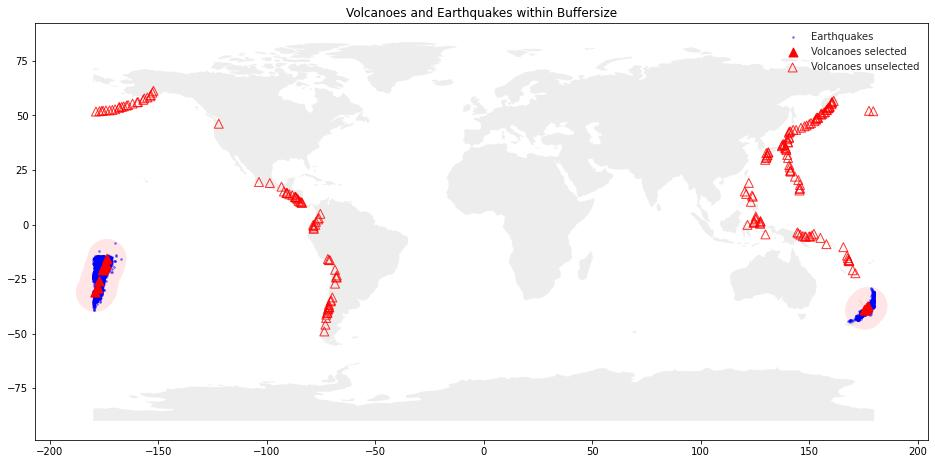

2025-01-22 22:04:31,862 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_tonga_kermadec/earthquakes_spatially_selected_250122-220431.csv'.
2025-01-22 22:04:32,034 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_tonga_kermadec/earthquakes_spatially_selected.csv'.
2025-01-22 22:04:32,037 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_tonga_kermadec/volcanoes_spatially_selected_250122-220432.csv'.
2025-01-22 22:04:32,041 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_tonga_kermadec/volcanoes_spatially_selected.csv'.
2025-01-22 22:04:32,043 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_tonga_kermadec/eruptions_spatially_selected_250122-220432.csv'.
2025-01-22 22:04:32,046 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_tonga_kermadec/eruptions_spatially_selected.csv'.


southwest_pacific with n = 21


,Volcano_Number,Volcano_Name,Region,geometry
14,251002,Kadovar,Southwest Pacific Volcanic Regions,"POLYGON ((153.57116 -3.60800, 153.52790 -4.488..."
15,251020,Manam,Southwest Pacific Volcanic Regions,"POLYGON ((154.02016 -4.08000, 153.97690 -4.960..."
16,251030,Karkar,Southwest Pacific Volcanic Regions,"POLYGON ((154.95916 -4.64700, 154.91590 -5.527..."
17,251050,Long Island,Southwest Pacific Volcanic Regions,"POLYGON ((156.10316 -5.35800, 156.05990 -6.238..."
18,251070,Ritter Island,Southwest Pacific Volcanic Regions,"POLYGON ((157.09816 -5.51900, 157.05490 -6.399..."
...,...,...,...,...
30,257050,Lopevi,Southwest Pacific Volcanic Regions,"POLYGON ((177.32916 -16.50700, 177.28590 -17.3..."
31,257060,East Epi,Southwest Pacific Volcanic Regions,"POLYGON ((177.37246 -16.67970, 177.32920 -17.5..."
32,257070,Kuwae,Southwest Pacific Volcanic Regions,"POLYGON ((177.50586 -16.83040, 177.46260 -17.7..."
33,258001,Gemini-Oscostar,Southwest Pacific Volcanic Regions,"POLYGON ((179.11316 -20.95700, 179.06990 -21.8..."


Earthquakes selected: 12761


2025-01-22 22:04:32,703 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set data directory for saving to './data/scope/gvp_1000/cluster_southwest_pacific'.
2025-01-22 22:04:33,475 - INFO - 252_spatial_operations_gvp_1000.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/gvp_1000/cluster_southwest_pacific'.


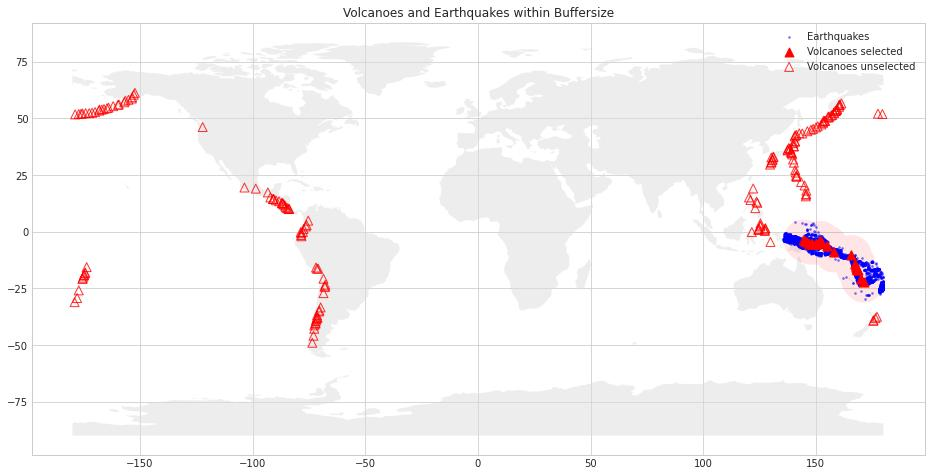

2025-01-22 22:04:33,834 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_southwest_pacific/earthquakes_spatially_selected_250122-220433.csv'.
2025-01-22 22:04:34,058 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_southwest_pacific/earthquakes_spatially_selected.csv'.
2025-01-22 22:04:34,062 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_southwest_pacific/volcanoes_spatially_selected_250122-220434.csv'.
2025-01-22 22:04:34,065 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_southwest_pacific/volcanoes_spatially_selected.csv'.
2025-01-22 22:04:34,068 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_southwest_pacific/eruptions_spatially_selected_250122-220434.csv'.
2025-01-22 22:04:34,072 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_southwest_pacific/eruptions_spatially_selected.csv'.


sunda_banda with n = 1


,Volcano_Number,Volcano_Name,Region,geometry
35,265090,Banda Api,Sunda-Banda Volcanic Regions,"POLYGON ((138.86416 -4.52300, 138.82090 -5.403..."


Earthquakes selected: 6062


2025-01-22 22:04:34,625 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set data directory for saving to './data/scope/gvp_1000/cluster_sunda_banda'.
2025-01-22 22:04:35,155 - INFO - 252_spatial_operations_gvp_1000.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/gvp_1000/cluster_sunda_banda'.


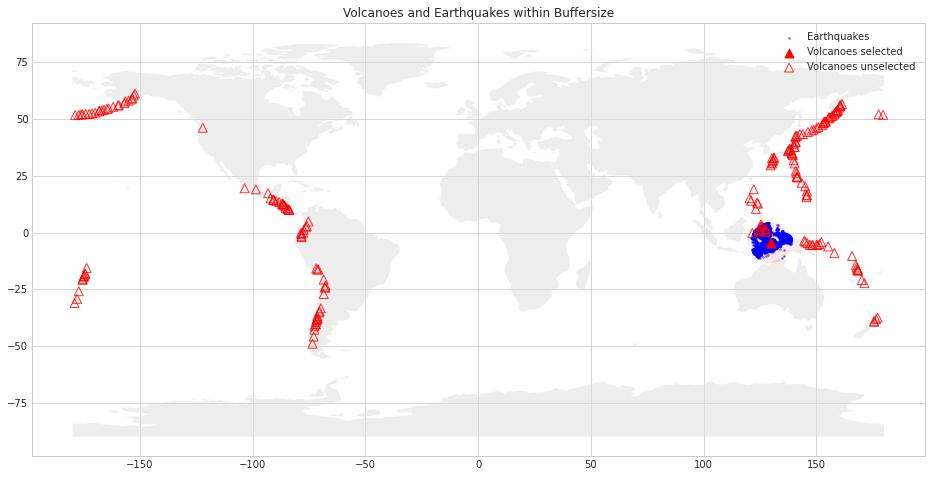

2025-01-22 22:04:35,359 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_sunda_banda/earthquakes_spatially_selected_250122-220435.csv'.
2025-01-22 22:04:35,466 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_sunda_banda/earthquakes_spatially_selected.csv'.
2025-01-22 22:04:35,469 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_sunda_banda/volcanoes_spatially_selected_250122-220435.csv'.
2025-01-22 22:04:35,472 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_sunda_banda/volcanoes_spatially_selected.csv'.
2025-01-22 22:04:35,473 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_sunda_banda/eruptions_spatially_selected_250122-220435.csv'.
2025-01-22 22:04:35,475 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_sunda_banda/eruptions_spatially_selected.csv'.


western_pacific with n = 27


,Volcano_Number,Volcano_Name,Region,geometry
36,266010,Colo,Western Pacific Volcanic Regions,"POLYGON ((130.58416 -0.16200, 130.54090 -1.042..."
37,266020,Ambang,Western Pacific Volcanic Regions,"POLYGON ((133.40316 0.75000, 133.35990 -0.1305..."
38,266030,Soputan,Western Pacific Volcanic Regions,"POLYGON ((133.72016 1.11200, 133.67690 0.23150..."
39,266100,Lokon-Empung,Western Pacific Volcanic Regions,"POLYGON ((133.77516 1.35800, 133.73190 0.47750..."
40,267010,Ruang,Western Pacific Volcanic Regions,"POLYGON ((134.35316 2.30000, 134.30990 1.41950..."
...,...,...,...,...
58,282100,Unzendake,Western Pacific Volcanic Regions,"POLYGON ((139.28216 32.76100, 139.23890 31.880..."
59,282110,Asosan,Western Pacific Volcanic Regions,"POLYGON ((140.06816 32.88490, 140.02490 32.004..."
60,282120,Kujusan,Western Pacific Volcanic Regions,"POLYGON ((140.23216 33.08600, 140.18890 32.205..."
63,283040,Ontakesan,Western Pacific Volcanic Regions,"POLYGON ((146.46316 35.89300, 146.41990 35.012..."


Earthquakes selected: 15832


2025-01-22 22:04:36,201 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set data directory for saving to './data/scope/gvp_1000/cluster_western_pacific'.
2025-01-22 22:04:37,007 - INFO - 252_spatial_operations_gvp_1000.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/gvp_1000/cluster_western_pacific'.


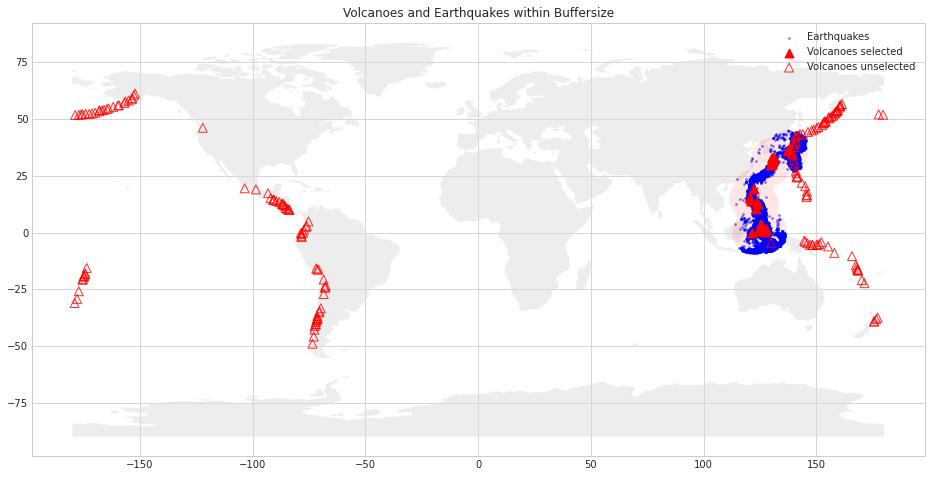

2025-01-22 22:04:37,410 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_western_pacific/earthquakes_spatially_selected_250122-220437.csv'.
2025-01-22 22:04:37,684 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_western_pacific/earthquakes_spatially_selected.csv'.
2025-01-22 22:04:37,687 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_western_pacific/volcanoes_spatially_selected_250122-220437.csv'.
2025-01-22 22:04:37,690 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_western_pacific/volcanoes_spatially_selected.csv'.
2025-01-22 22:04:37,694 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_western_pacific/eruptions_spatially_selected_250122-220437.csv'.
2025-01-22 22:04:37,698 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_western_pacific/eruptions_spatially_selected.csv'.


northwest_pacific with n = 58


,Volcano_Number,Volcano_Name,Region,geometry
61,283010,Izu-Tobu,Northwest Pacific Volcanic Regions,"POLYGON ((148.08116 34.90000, 148.03790 34.019..."
62,283020,Hakoneyama,Northwest Pacific Volcanic Regions,"POLYGON ((148.00416 35.23300, 147.96090 34.352..."
65,283090,Niigata-Yakeyama,Northwest Pacific Volcanic Regions,"POLYGON ((147.01916 36.92100, 146.97590 36.040..."
66,283110,Asamayama,Northwest Pacific Volcanic Regions,"POLYGON ((147.50616 36.40600, 147.46290 35.525..."
67,283120,Kusatsu-Shiranesan,Northwest Pacific Volcanic Regions,"POLYGON ((147.51116 36.61800, 147.46790 35.737..."
...,...,...,...,...
116,300240,Tolbachik,Northwest Pacific Volcanic Regions,"POLYGON ((169.30916 55.83200, 169.26590 54.951..."
117,300250,Bezymianny,Northwest Pacific Volcanic Regions,"POLYGON ((169.57816 55.97200, 169.53490 55.091..."
118,300260,Klyuchevskoy,Northwest Pacific Volcanic Regions,"POLYGON ((169.62516 56.05600, 169.58190 55.175..."
119,300270,Sheveluch,Northwest Pacific Volcanic Regions,"POLYGON ((170.34316 56.65300, 170.29990 55.772..."


Earthquakes selected: 10230


2025-01-22 22:04:38,345 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set data directory for saving to './data/scope/gvp_1000/cluster_northwest_pacific'.
2025-01-22 22:04:39,002 - INFO - 252_spatial_operations_gvp_1000.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/gvp_1000/cluster_northwest_pacific'.


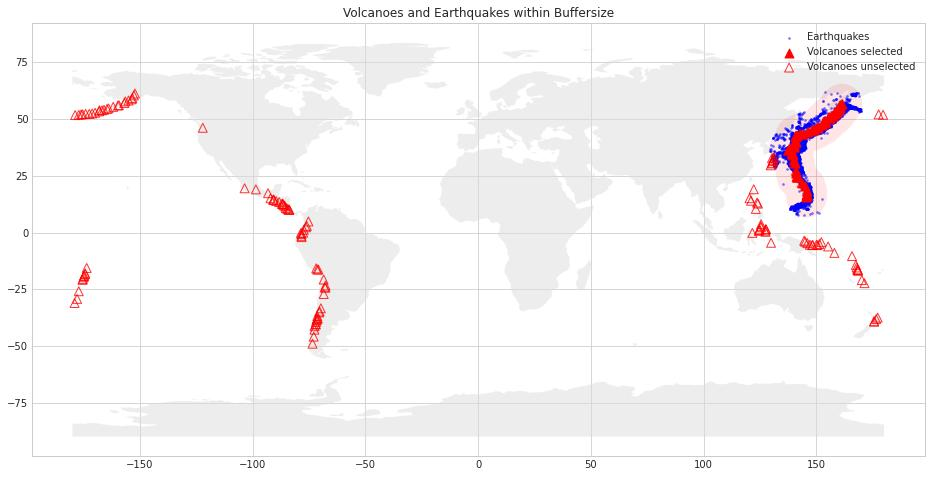

2025-01-22 22:04:39,293 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_northwest_pacific/earthquakes_spatially_selected_250122-220439.csv'.
2025-01-22 22:04:39,471 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_northwest_pacific/earthquakes_spatially_selected.csv'.
2025-01-22 22:04:39,475 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_northwest_pacific/volcanoes_spatially_selected_250122-220439.csv'.
2025-01-22 22:04:39,479 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_northwest_pacific/volcanoes_spatially_selected.csv'.
2025-01-22 22:04:39,483 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_northwest_pacific/eruptions_spatially_selected_250122-220439.csv'.
2025-01-22 22:04:39,488 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_northwest_pacific/eruptions_spatially_selected.csv'.


north_america with n = 27


,Volcano_Number,Volcano_Name,Region,geometry
120,311020,Kiska,North America Volcanic Regions,"POLYGON ((186.58516 52.10300, 186.54190 51.222..."
121,311060,Semisopochnoi,North America Volcanic Regions,"POLYGON ((188.56316 51.93000, 188.51990 51.049..."
122,311070,Gareloi,North America Volcanic Regions,"POLYGON ((-169.81084 51.79000, -169.85410 50.9..."
123,311110,Kanaga,North America Volcanic Regions,"POLYGON ((-168.18484 51.92300, -168.22810 51.0..."
124,311120,Great Sitkin,North America Volcanic Regions,"POLYGON ((-167.14684 52.07600, -167.19010 51.1..."
...,...,...,...,...
142,312260,Fourpeaked,North America Volcanic Regions,"POLYGON ((-144.68884 58.77000, -144.73210 57.8..."
143,313010,Augustine,North America Volcanic Regions,"POLYGON ((-144.45184 59.36260, -144.49510 58.4..."
144,313030,Redoubt,North America Volcanic Regions,"POLYGON ((-143.75884 60.48500, -143.80210 59.6..."
145,313040,Spurr,North America Volcanic Regions,"POLYGON ((-143.26784 61.29900, -143.31110 60.4..."


Earthquakes selected: 2948


2025-01-22 22:04:40,168 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set data directory for saving to './data/scope/gvp_1000/cluster_north_america'.
2025-01-22 22:04:40,618 - INFO - 252_spatial_operations_gvp_1000.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/gvp_1000/cluster_north_america'.


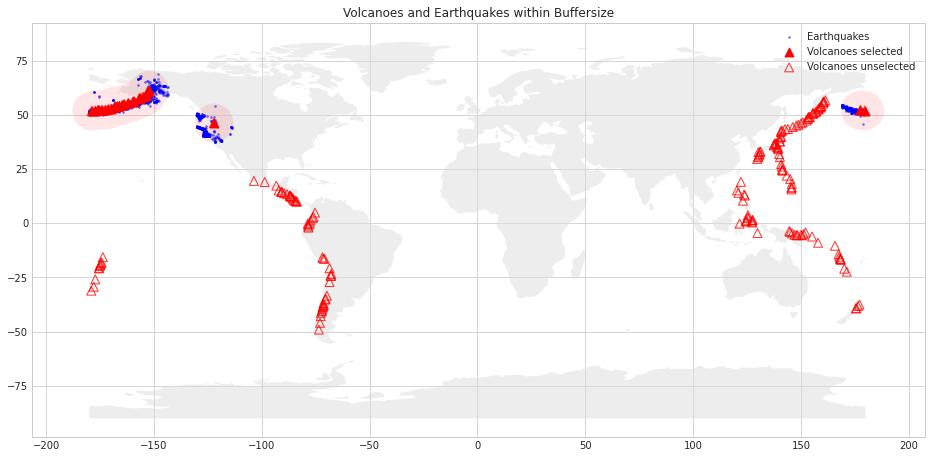

2025-01-22 22:04:40,758 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_north_america/earthquakes_spatially_selected_250122-220440.csv'.
2025-01-22 22:04:40,812 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_north_america/earthquakes_spatially_selected.csv'.
2025-01-22 22:04:40,815 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_north_america/volcanoes_spatially_selected_250122-220440.csv'.
2025-01-22 22:04:40,818 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_north_america/volcanoes_spatially_selected.csv'.
2025-01-22 22:04:40,821 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_north_america/eruptions_spatially_selected_250122-220440.csv'.
2025-01-22 22:04:40,824 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_north_america/eruptions_spatially_selected.csv'.


middle_america_caribbean with n = 20


,Volcano_Number,Volcano_Name,Region,geometry
147,341040,Colima,Middle America-Caribbean Volcanic Regions,"POLYGON ((-94.63684 19.51400, -94.68010 18.633..."
148,341090,Popocatepetl,Middle America-Caribbean Volcanic Regions,"POLYGON ((-89.63884 19.02300, -89.68210 18.142..."
149,341120,"Chichon, El",Middle America-Caribbean Volcanic Regions,"POLYGON ((-84.24654 17.36020, -84.28980 16.479..."
150,341130,Tacana,Middle America-Caribbean Volcanic Regions,"POLYGON ((-83.12584 15.13200, -83.16910 14.251..."
151,342080,Acatenango,Middle America-Caribbean Volcanic Regions,"POLYGON ((-81.89284 14.50100, -81.93610 13.620..."
152,342090,Fuego,Middle America-Caribbean Volcanic Regions,"POLYGON ((-81.89684 14.47300, -81.94010 13.592..."
153,342110,Pacaya,Middle America-Caribbean Volcanic Regions,"POLYGON ((-81.61784 14.38200, -81.66110 13.501..."
154,343020,Santa Ana,Middle America-Caribbean Volcanic Regions,"POLYGON ((-80.64684 13.85300, -80.69010 12.972..."
155,343100,San Miguel,Middle America-Caribbean Volcanic Regions,"POLYGON ((-79.28584 13.43400, -79.32910 12.553..."
156,344020,San Cristobal,Middle America-Caribbean Volcanic Regions,"POLYGON ((-78.02084 12.70200, -78.06410 11.821..."


Earthquakes selected: 2874


2025-01-22 22:04:41,394 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set data directory for saving to './data/scope/gvp_1000/cluster_middle_america_caribbean'.
2025-01-22 22:04:41,839 - INFO - 252_spatial_operations_gvp_1000.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/gvp_1000/cluster_middle_america_caribbean'.


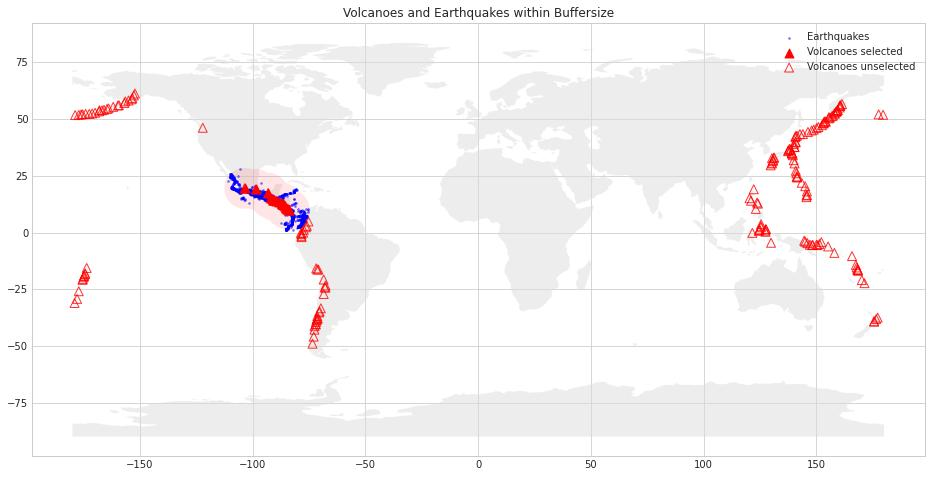

2025-01-22 22:04:41,980 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_middle_america_caribbean/earthquakes_spatially_selected_250122-220441.csv'.
2025-01-22 22:04:42,032 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_middle_america_caribbean/earthquakes_spatially_selected.csv'.
2025-01-22 22:04:42,035 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_middle_america_caribbean/volcanoes_spatially_selected_250122-220442.csv'.
2025-01-22 22:04:42,038 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_middle_america_caribbean/volcanoes_spatially_selected.csv'.
2025-01-22 22:04:42,042 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_middle_america_caribbean/eruptions_spatially_selected_250122-220442.csv'.
2025-01-22 22:04:42,045 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_middle_america_caribbean/eruptions_s

south_america with n = 32


,Volcano_Number,Volcano_Name,Region,geometry
167,351020,"Ruiz, Nevado del",South America Volcanic Regions,"POLYGON ((-66.34084 4.89200, -66.38410 4.01150..."
168,351050,"Huila, Nevado del",South America Volcanic Regions,"POLYGON ((-67.04684 2.93000, -67.09010 2.04950..."
169,351060,Purace,South America Volcanic Regions,"POLYGON ((-67.41684 2.32000, -67.46010 1.43950..."
170,351080,Galeras,South America Volcanic Regions,"POLYGON ((-68.38684 1.22000, -68.43010 0.33950..."
171,352010,Reventador,South America Volcanic Regions,"POLYGON ((-68.67284 -0.07700, -68.71610 -0.957..."
...,...,...,...,...
194,357150,Puyehue-Cordon Caulle,South America Volcanic Regions,"POLYGON ((-63.13384 -40.59000, -63.17710 -41.4..."
195,358020,Calbuco,South America Volcanic Regions,"POLYGON ((-63.63484 -41.33000, -63.67810 -42.2..."
196,358041,Chaiten,South America Volcanic Regions,"POLYGON ((-63.66824 -42.83490, -63.71150 -43.7..."
197,358057,"Hudson, Cerro",South America Volcanic Regions,"POLYGON ((-63.98684 -45.90000, -64.03010 -46.7..."


Earthquakes selected: 6285


2025-01-22 22:04:42,663 - INFO - 252_spatial_operations_gvp_1000.ipynb: Set data directory for saving to './data/scope/gvp_1000/cluster_south_america'.
2025-01-22 22:04:43,315 - INFO - 252_spatial_operations_gvp_1000.ipynb: Saving 25_Buffered_Earthquakes.png to './data/scope/gvp_1000/cluster_south_america'.


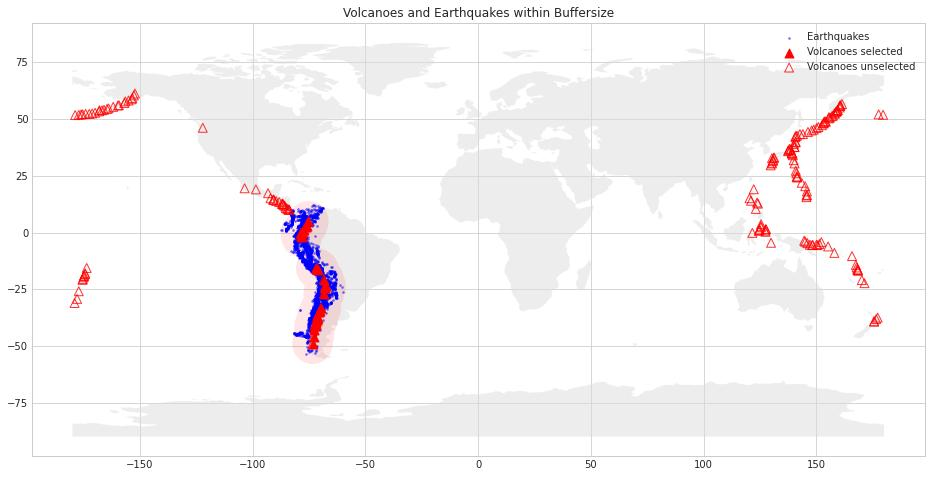

2025-01-22 22:04:43,531 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_south_america/earthquakes_spatially_selected_250122-220443.csv'.
2025-01-22 22:04:43,644 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_south_america/earthquakes_spatially_selected.csv'.
2025-01-22 22:04:43,648 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_south_america/volcanoes_spatially_selected_250122-220443.csv'.
2025-01-22 22:04:43,651 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_south_america/volcanoes_spatially_selected.csv'.
2025-01-22 22:04:43,654 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_south_america/eruptions_spatially_selected_250122-220443.csv'.
2025-01-22 22:04:43,658 - INFO - save_dataset: Data saved successfully to 'data/scope/gvp_1000/cluster_south_america/eruptions_spatially_selected.csv'.


In [16]:
import re

# loop over all unique regions
for region in volcanoes_selected_gdf['Region'].unique():
    # new cluster
    print("="*120)
    
    # subset of volcanoes in this region
    volcanoes_selected_gdf_subset = volcanoes_selected_gdf[volcanoes_selected_gdf['Region'] == region]
    
    # filter eruptions_selected to only include rows where Volcano_Number exists in volcanoes_selected_gdf_subset
    eruptions_selected_subset = eruptions_selected[
        eruptions_selected['Volcano_Number'].isin(volcanoes_selected_gdf_subset['Volcano_Number'])
    ]
    
    # construct a more simple regional name
    cluster_name = re.match(r'^(.*?)\s*Volcanic Regions$', region).group(1)
    cluster_name= re.sub(r'[ \-]', '_', cluster_name.lower())
    
    # show some infos
    print(f"{cluster_name} with n = {len(volcanoes_selected_gdf_subset)}")

    # set individual datadir for saving
    data_dir_cluster = os.path.join(data_dir, "cluster_" + str(cluster_name))

    # make a new geopandas dataframe
    volcanoes_selected_gdf_buffers = volcanoes_selected_gdf_subset[
        ['Volcano_Number', 'Volcano_Name', 'Region', 'geometry']].copy()

    # buffer distance in meters
    buffer_distance = parameters.buffer_size_km * 1000

    # generate a buffer with different radius for lat/lon
    volcanoes_selected_gdf_buffers['geometry'] = volcanoes_selected_gdf_subset.apply(
        lambda row: row.geometry.buffer(
            meters_to_degrees(buffer_distance, row.geometry.y)[0]
        ), axis=1
    )    
    
    # combine all single buffers into a single buffer
    volcano_buffers_combined = volcanoes_selected_gdf_buffers['geometry'].unary_union
    display(volcanoes_selected_gdf_buffers)
    
    # Find rows in 'eq' that are spatially inside 'volcano_geometry'
    earthquakes_spatially_selected_gdf = \
        earthquakes_selected_gdf[earthquakes_selected_gdf['geometry'].within(volcano_buffers_combined)]    
    print(f'Earthquakes selected: {len(earthquakes_spatially_selected_gdf)}')

    # ensure data dir is in place
    time.sleep(0.5)
    os.makedirs(data_dir_cluster, exist_ok=True)
    logging.info(f"{script_name}: Set data directory for saving to './{data_dir_cluster}'.")

    # show the complete results (volcanoes & earthquakes)
    fig, ax = plt.subplots(figsize=(16, 10))
    plt.style.use('seaborn-whitegrid')
    world.plot(ax=ax, color="#dddddd", edgecolor=None, alpha=0.5)
    gpd.GeoSeries([volcano_buffers_combined]).plot(ax=ax, color='red', alpha=0.1, edgecolor=None, label='Buffer')
    earthquakes_spatially_selected_gdf.plot(ax=ax, color='blue', marker='o', label='Earthquakes', markersize=3, alpha=0.4)
    volcanoes_selected_gdf_subset.plot(ax=ax, markersize=80, color='red', alpha=1.0, label='Volcanoes selected', marker='^')
    volcanoes_selected_gdf.plot(ax=ax, markersize=80, color='none', edgecolor="red", alpha=0.8, label='Volcanoes unselected', marker='^')
    plt.title('Volcanoes and Earthquakes within Buffersize')
    plt.legend()
    plt.savefig(os.path.join(data_dir_cluster, "25_Buffered_Earthquakes.png"), format='png', dpi=150, bbox_inches='tight')
    logging.info(f"{script_name}: Saving 25_Buffered_Earthquakes.png to './{data_dir_cluster}'.")
    plt.show()    
    
    # save spatially selected earthquake dataset (for this cluster)
    save_dataset(data_file = "earthquakes_spatially_selected.csv", 
                 data_dir = data_dir_cluster, 
                 data_set = earthquakes_spatially_selected_gdf,
                 append_datetime=True,
                 overwrite_file=False
                )  
    # save spatially selected earthquake dataset (for this cluster)
    save_dataset(data_file = "earthquakes_spatially_selected.csv", 
                 data_dir = data_dir_cluster, 
                 data_set = earthquakes_spatially_selected_gdf,
                 append_datetime=False,
                 overwrite_file=True
                )  
    
    # save spatially selected volcanoes dataset (for this cluster)
    save_dataset(data_file = "volcanoes_spatially_selected.csv", 
                 data_dir = data_dir_cluster, 
                 data_set = volcanoes_selected_gdf_subset,
                 append_datetime=True,
                 overwrite_file=False
                )  
    # save spatially selected volcanoes dataset (for this cluster)
    save_dataset(data_file = "volcanoes_spatially_selected.csv", 
                 data_dir = data_dir_cluster, 
                 data_set = volcanoes_selected_gdf_subset,
                 append_datetime=False,
                 overwrite_file=True
                )  

    # save spatially selected eruptions dataset (for this cluster)
    save_dataset(data_file = "eruptions_spatially_selected.csv", 
                 data_dir = data_dir_cluster, 
                 data_set = eruptions_selected_subset,
                 append_datetime=True,
                 overwrite_file=False
                )  
    # save spatially selected eruptions dataset (for this cluster)
    save_dataset(data_file = "eruptions_spatially_selected.csv", 
                 data_dir = data_dir_cluster, 
                 data_set = eruptions_selected_subset,
                 append_datetime=False,
                 overwrite_file=True
                )  
    
# last cluster
print("="*120)    

## End of script

In [17]:
# log the end of this script
logging.info(f"End of script '{script_name}'.")

2025-01-22 22:04:43,663 - INFO - End of script '252_spatial_operations_gvp_1000.ipynb'.


## Appendix

In [18]:
%%js

// -------------------------------------------
// What are the headings of this document?
// --> Get a better overview of the structure.
// -------------------------------------------

function listHeadings() {
    let headings = [];
    let cells = Jupyter.notebook.get_cells();
    
    cells.forEach((cell) => {
        if (cell.cell_type == 'markdown') {
            let text = cell.get_text();
            let lines = text.split('\n');
            
            lines.forEach((line) => {
                let match = line.match(/^(#+)\s+(.*)/);
                if (match) {
                    headings.push({
                        level: match[1].length, // Number of # symbols indicates the heading level
                        text: match[2].trim()
                    });
                }
            });
        }
    });
    return headings;
}

let headings = listHeadings();
headings.forEach((heading) => {
    let markdown = `${'#'.repeat(heading.level)} ${heading.text}`;
    element.append(`${markdown}<br>`);
});

<IPython.core.display.Javascript object>

## Save notebook as experimentation protocol

In [19]:
# save notebook as a experimentation protocol
time.sleep(2)
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(2)
save_notebook_as_html(script_name, data_dir_cluster)

<IPython.core.display.Javascript object>

Notebook saved as HTML: data/scope/gvp_1000/cluster_south_america/252_spatial_operations_gvp_1000.html
